In [1]:
# For data analysis
import os
import numpy as np
import pandas as pd

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt 
from pylab import rcParams
%matplotlib inline

In [2]:
rcParams['figure.figsize'] = [16, 9]
# rcParams["font.family"] = "Helvetica"
sns.set_context("paper", font_scale=2.5)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('show_dimensions', True)

In [3]:
# set path
data_path = "D:\\EGI_DATA\\EGI_FMT"
beh_path = "beh"
new_data_path = "new_data"
# set task name
foodtask = "foodchoice"
wordtask = "wordchoice"
imagetask = "imagechoice"
witask = "wordimagematch"

In [4]:
max_time = 3000
# read animacy table
animacy_path = "./assets/animacy.xlsx"
association_path = "./assets/association.csv"
animacy = pd.read_excel(animacy_path, sheet_name=0)
association = pd.read_csv(association_path)

In [5]:
# get animacy dict of words
animacy_dict = {}
for index, row in animacy.iterrows():
    animacy_dict[row["animate"]] = "animate"
    animacy_dict[row["non-animate"]] = "inanimate"

In [6]:
# word/image match dict in wordimageChoice task
association["relation"] = association.isMatch.map({True: "match", False: "nomatch"})
association = association[["item_word", "item_image", "relation"]]
association.drop_duplicates(inplace=True)
match_dict = {}
for index, row in association.iterrows():
    match_dict[row["item_word"]] = row["relation"]
    match_dict[row["item_image"]] = row["relation"]

In [7]:
def get_file_path(sub, task):
    file_path = os.path.join(data_path, sub, beh_path, "{}_task-{}_beh.csv".format(sub, task))
    if not os.path.exists(file_path):
        print("missing: {}".format(file_path))
        return None
    return file_path

## foodChoice

In [8]:
food_columns = pd.read_csv(get_file_path("sub-001", foodtask)).columns
food_df = pd.DataFrame(columns=food_columns)
time_list = []
for sub in os.listdir(data_path):
    file_path = get_file_path(sub, foodtask)
    if file_path is None:
        continue
    df = pd.read_csv(file_path)
    # delete first and last row, then concat dataframes
    time_list.append(df["text.started"][321])
    food_df = pd.concat([food_df, df[1:321]], ignore_index=True)
np.mean(time_list) / 60

27.13630048475568

In [9]:
food_df["rt"] = food_df[["image_right.started", "image_right_2.started"]].apply(lambda x: np.round((x["image_right_2.started"] - x["image_right.started"]) * 1000), axis=1)

In [10]:
food_df.rt

0       1847.0
1       2279.0
2       1762.0
3       2281.0
4       1718.0
         ...  
9915     833.0
9916    1092.0
9917     963.0
9918     885.0
9919     921.0
Name: rt, Length: 9920, dtype: float64

In [11]:
food_df = food_df[food_df["rt"] < max_time]

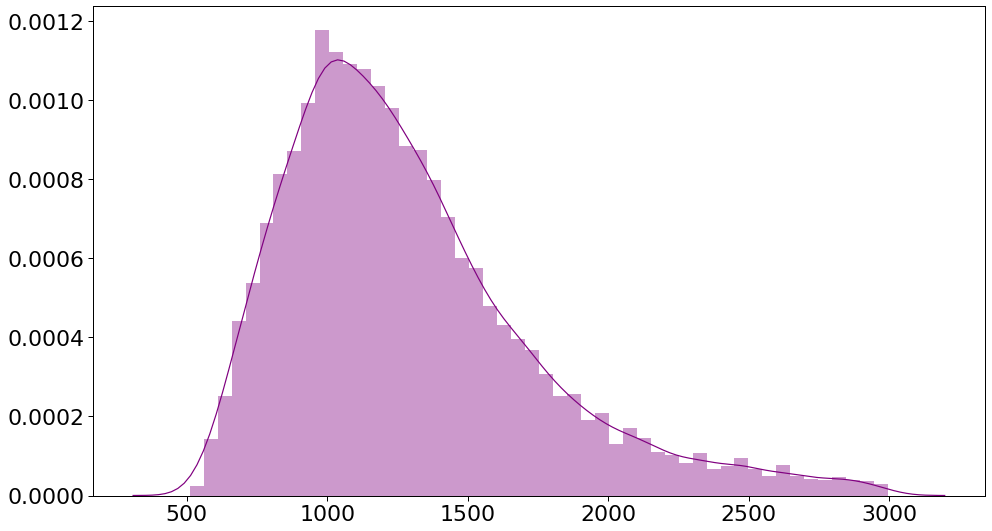

In [58]:
fig = sns.distplot(food_df["rt"], color="purple")
# ticks = fig.get_yticks().tolist() + [0.0016]
# ylabels = ['{:.2f}'.format(x * 100) for x in fig.get_yticks()]
# fig.set_yticklabels(ylabels)
# fig.set_yticks(ticks)
plt.xlabel("")
plt.ylabel("")
plt.legend([],[], frameon=False)
# plt.title("Food Choice RT", y=1.01)
plt.savefig("./figures/foodchoice/rt.svg", bbox_inches="tight")

## wordChoice

In [13]:
word_columns = pd.read_csv(get_file_path("sub-001", wordtask)).columns
word_df = pd.DataFrame(columns=word_columns)

In [14]:
time_list = []
for sub in os.listdir(data_path):
    file_path = get_file_path(sub, wordtask)
    if file_path is None:
        continue
    df = pd.read_csv(file_path)
    # delete first and last row, then concat dataframes
    time_list.append(df["text.started"][321])
    word_df = pd.concat([word_df, df[1:321]], ignore_index=True)

In [15]:
np.mean(time_list) / 60

25.276793611547777

In [16]:
# rename option
for option in ["option_left", "option_right"]:
    word_df[option] = word_df[option].map({"有生命":"animate", "无生命":"inanimate"})
# rename mouse.clicked_name columns
word_df["mouse.clicked_name"] = word_df["mouse.clicked_name"].map({"rect_left":"left", "rect_right":"right"})
word_df.rename(columns={"mouse.clicked_name":"side"}, inplace=True)

In [17]:
# get animacy of word
word_df["animacy"] = word_df["item"].apply(lambda x: animacy_dict[x])
# match relation in wordimageChoice
word_df["relation"] = word_df["item"].apply(lambda x: match_dict[x])
# get rt
word_df["rt"] = word_df[["word_item.started", "word_item_2.started"]].apply(lambda x: np.round((x["word_item_2.started"] - x["word_item.started"]) * 1000), axis=1)
# get mouse response
word_df["response"] = word_df.apply(lambda x: x["option_left"] if x["side"] == "left" else x["option_right"], axis=1)
# calculate correct
word_df["correct"] = word_df.apply(lambda x: x["animacy"] == x["response"], axis=1)

In [18]:
word_df = word_df[word_df["rt"] < max_time]

### wordChoice RT

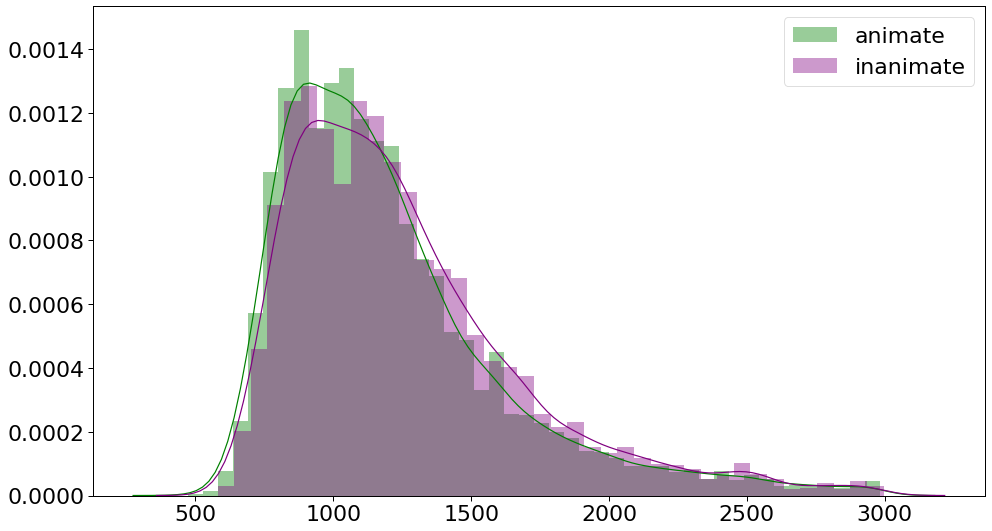

In [60]:
# animate/non-animate
fig = sns.distplot(word_df[word_df["animacy"] == "animate"]["rt"], color="green", label="animate")
sns.distplot(word_df[word_df["animacy"] == "inanimate"]["rt"], color="purple", label="inanimate")
plt.legend()
plt.xlabel("")
plt.ylabel("")
# plt.title("Word Choice RT", y=1.01)
plt.savefig("./figures/wordchoice/rt-animacy.svg", bbox_inches="tight")

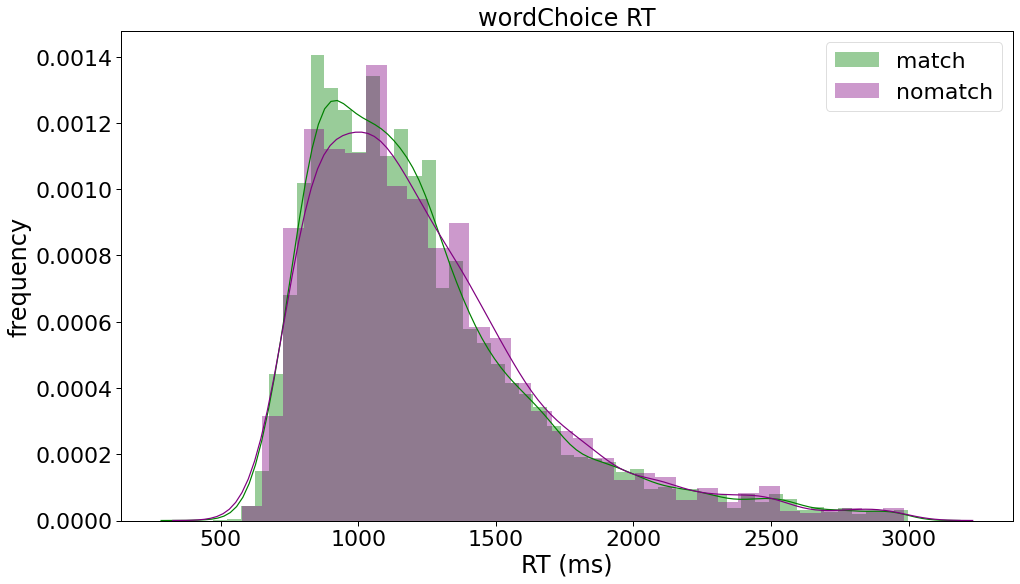

In [20]:
# match/nomatch
sns.distplot(word_df[word_df["relation"] == "match"]["rt"], color="green", label="match")
sns.distplot(word_df[word_df["relation"] == "nomatch"]["rt"], color="purple", label="nomatch")
plt.legend()
plt.xlabel("RT (ms)")
plt.ylabel("frequency")
plt.title("wordChoice RT")
plt.savefig("./figures/wordchoice/rt-match.svg", bbox_inches="tight")

### wordChoice accuracy

In [21]:
word_df[word_df["animacy"] == "animate"]["correct"].sum() / word_df[word_df["animacy"] == "animate"].shape[0]

0.9796722671644887

In [22]:
word_df[word_df["animacy"] == "inanimate"]["correct"].sum() / word_df[word_df["animacy"] == "inanimate"].shape[0]

0.9470417873396773

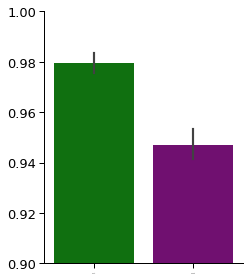

In [102]:
# accuracy
fig = sns.catplot(x="animacy", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=word_df, aspect=0.9)
fig.set(ylim=(0.9, 1))
# plt.xlabel("condition")
plt.xlabel("")
plt.ylabel("")
plt.xticks(size=0)
plt.yticks(size=13)
# plt.title("Word Choice Accuracy", y=1.01)
plt.savefig("./figures/wordchoice/acc-animacy.svg", bbox_inches="tight")

In [24]:
word_df[word_df["relation"] == "match"]["correct"].sum() / word_df[word_df["relation"] == "match"].shape[0]

0.9689355239541626

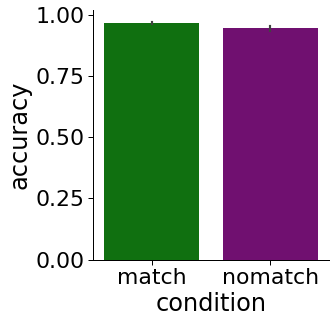

In [25]:
# accuracy
sns.catplot(x="relation", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=word_df)
plt.xlabel("condition")
plt.ylabel("accuracy")
# plt.title("wordChoice accuracy")
plt.savefig("./figures/wordchoice/acc-match.svg", bbox_inches="tight")

## imageChoice

In [26]:
image_columns = pd.read_csv(get_file_path("sub-001", imagetask)).columns
image_df = pd.DataFrame(columns=image_columns)

In [27]:
time_list = []
for sub in os.listdir(data_path):
    file_path = get_file_path(sub, imagetask)
    if file_path is None:
        continue
    df = pd.read_csv(file_path)
    time_list.append(df["text.started"][321])
    image_df = pd.concat([image_df, df[1:321]], ignore_index=True)

In [28]:
np.mean(time_list)/60

25.943579970740725

In [29]:
# rename option
for option in ["option_left", "option_right"]:
    image_df[option] = image_df[option].map({"有生命": "animate", "无生命": "inanimate"})
# rename mouse.clicked_name columns
image_df["mouse.clicked_name"] = image_df["mouse.clicked_name"].map({"rect_left": "left", "rect_right": "right"})
image_df.rename(columns={"mouse.clicked_name":"side"}, inplace=True)

In [30]:
# get animacy of image
image_df["animacy"] = image_df["item"].apply(lambda x: x.split("/")[0])
image_df["animacy"] = image_df["animacy"].map({"animate": "animate", "non-animate": "inanimate"})
# match relation in wordimageChoice
image_df["relation"] = image_df["item"].apply(lambda x: match_dict[x])
# get rt
image_df["rt"] = image_df[["image_item.started", "image_item_2.started"]].apply(lambda x: np.round((x["image_item_2.started"] - x["image_item.started"]) * 1000), axis=1)
# get mouse response
image_df["response"] = image_df.apply(lambda x: x["option_left"] if x["side"] == "left" else x["option_right"], axis=1)
# calculate correct
image_df["correct"] = image_df.apply(lambda x: x["animacy"] == x["response"], axis=1)

In [31]:
image_df = image_df[image_df["rt"] < max_time]

### imageChoice RT

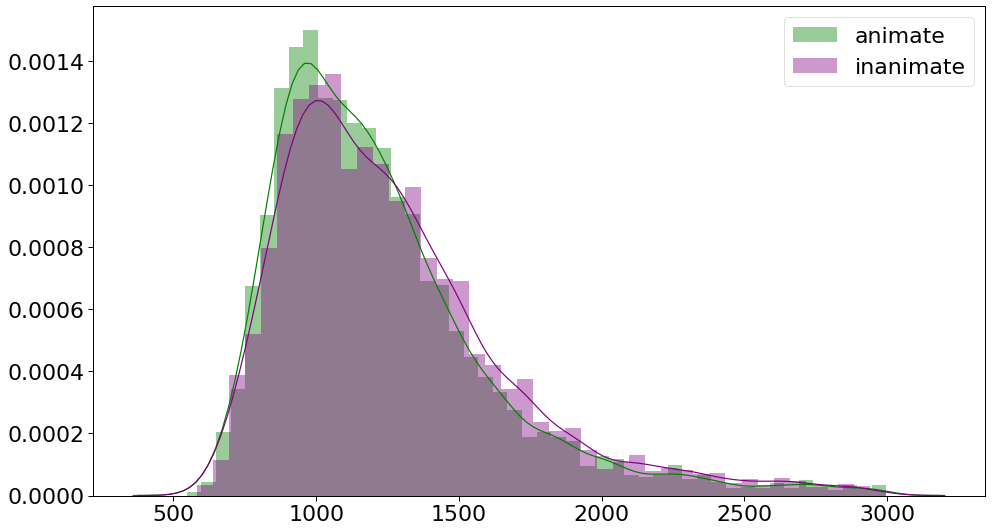

In [61]:
# animate/non-animate
fig = sns.distplot(image_df[image_df["animacy"] == "animate"]["rt"], color="green", label="animate")
sns.distplot(image_df[image_df["animacy"] == "inanimate"]["rt"], color="purple", label="inanimate")
# ylabels = ['{:.2f}'.format(x) for x in fig.get_yticks() * 100]
# fig.set_yticklabels(ylabels)
plt.legend()
plt.xlabel("")
plt.ylabel("")
# plt.title("Image Choice RT", y=1.01)
plt.savefig("./figures/imagechoice/rt-animacy.svg", bbox_inches="tight")

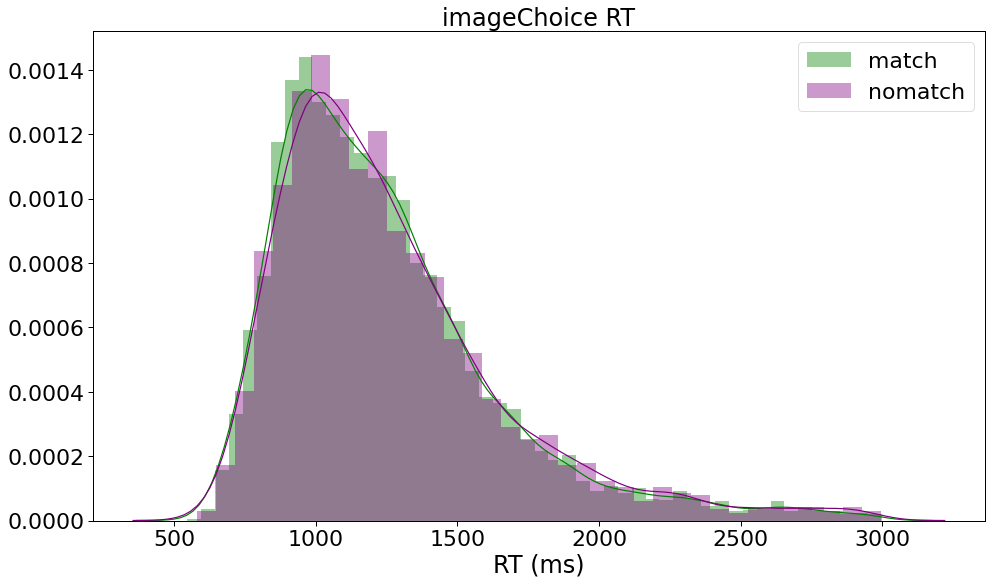

In [34]:
# match/nomatch
sns.distplot(image_df[image_df["relation"] == "match"]["rt"], color="green", label="match")
sns.distplot(image_df[image_df["relation"] == "nomatch"]["rt"], color="purple", label="nomatch")
plt.legend()
plt.xlabel("RT (ms)")
plt.title("imageChoice RT")
plt.savefig("./figures/imagechoice/rt-match.svg", bbox_inches="tight")

### imageChoice acc

In [35]:
image_df[image_df["animacy"] == "animate"]["correct"].sum() / image_df[image_df["animacy"] == "animate"].shape[0]

0.9860735813760133

In [36]:
image_df[image_df["animacy"] == "inanimate"]["correct"].sum() / image_df[image_df["animacy"] == "inanimate"].shape[0]

0.9499896244034032

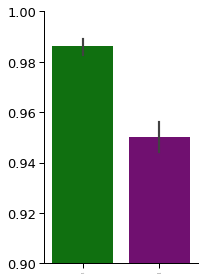

In [98]:
# accuracy
fig = sns.catplot(x="animacy", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=image_df, aspect=0.9)
fig.set(ylim=(0.9, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(size=0)
plt.yticks(size=13)
# plt.title("Image Choice Accuracy", y=1.01)
plt.savefig("./figures/imagechoice/acc-animacy.svg", bbox_inches="tight")

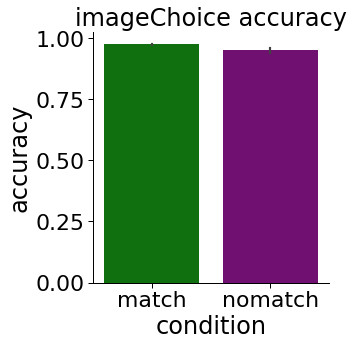

In [38]:
# accuracy
sns.catplot(x="relation", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=image_df)
plt.xlabel("condition")
plt.ylabel("accuracy")
plt.title("imageChoice accuracy")
plt.savefig("./figures/imagechoice/acc-match.svg", bbox_inches="tight")

In [39]:
word_df["stimuli"] = "word"
image_df["stimuli"] = "image"
merge_df = pd.concat([word_df[["stimuli", "item", "relation", "animacy", "correct"]], image_df[["stimuli", "item", "relation", "animacy", "correct"]]], ignore_index=True)

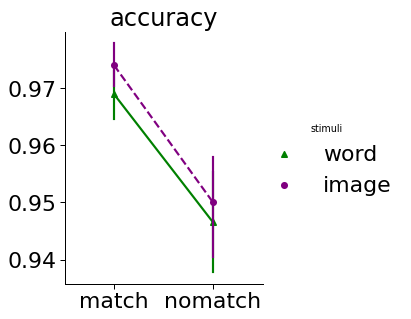

In [40]:
# accuracy
# sns.catplot(x="relation", y="correct", hue="stimuli", kind="bar", data=merge_df)
sns.catplot(x="relation", y="correct", hue="stimuli", kind="point", palette={"word": "green", "image": "purple"}, markers=["^", "o"], linestyles=["-", "--"], data=merge_df)
plt.xlabel("")
plt.ylabel("")
plt.title("accuracy")
plt.savefig("./figures/acc-match.svg", bbox_inches="tight")

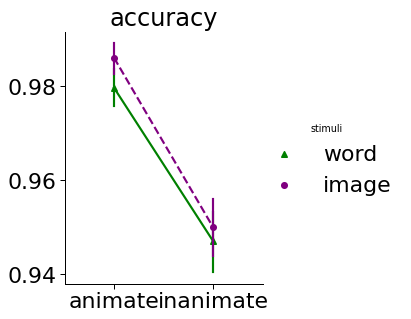

In [41]:
# accuracy
# sns.catplot(x="animacy", y="correct", hue="stimuli", kind="bar", data=merge_df)
sns.catplot(x="animacy", y="correct", hue="stimuli", kind="point", palette={"word": "green", "image": "purple"}, markers=["^", "o"], linestyles=["-", "--"], data=merge_df)
plt.xlabel("")
plt.ylabel("")
plt.title("accuracy")
plt.savefig("./figures/acc-animacy.svg", bbox_inches="tight")

## wordImageChoice

In [42]:
wi_columns = pd.read_csv(get_file_path("sub-001", witask)).columns
wi_df = pd.DataFrame(columns=wi_columns)

In [43]:
for sub in os.listdir(data_path):
    file_path = get_file_path(sub, witask)
    if file_path is None:
        continue
    df = pd.read_csv(file_path)
    wi_df = pd.concat([wi_df, df[1:321]], ignore_index=True)

In [44]:
# rename option
for option in ["option_left", "option_right"]:
    wi_df[option] = wi_df[option].map({"匹配":"match", "不匹配":"nomatch"})
# rename mouse.clicked_name columns
wi_df["mouse.clicked_name"] = wi_df["mouse.clicked_name"].map({"rect_left":"left", "rect_right":"right"})
wi_df.rename(columns={"mouse.clicked_name":"side"}, inplace=True)

In [45]:
# get animacy of word
wi_df["animacy"] = wi_df["item_word"].apply(lambda x: animacy_dict[x])
# match or not
wi_df["relation"] = wi_df["isMatch"].map({True:"match", False:"nomatch"})
# get rt
wi_df["rt"] = wi_df[["word_item.started", "word_item_2.started"]].apply(lambda x: np.round((x["word_item_2.started"] - x["word_item.started"]) * 1000), axis=1)
# get mouse response
wi_df["response"] = wi_df.apply(lambda x: x["option_left"] if x["side"] == "left" else x["option_right"], axis=1)
# calculate correct
wi_df["correct"] = wi_df.apply(lambda x: x["relation"] == x["response"], axis=1)

In [46]:
wi_df = wi_df[wi_df["rt"] < max_time]

### wordImageChoice RT

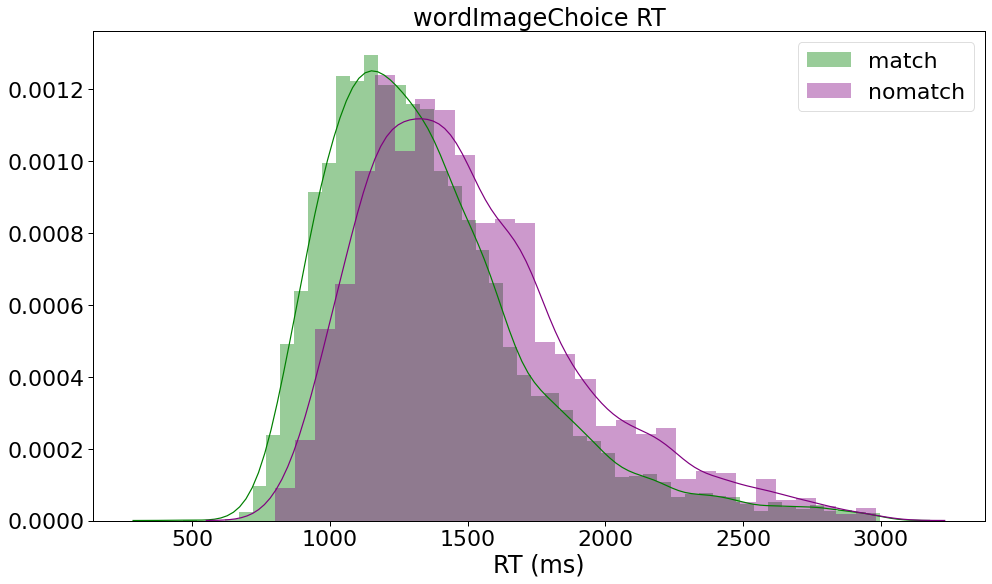

In [47]:
# match/nomatch
sns.distplot(wi_df[wi_df["relation"] == "match"]["rt"], color="green", label="match")
sns.distplot(wi_df[wi_df["relation"] == "nomatch"]["rt"], color="purple", label="nomatch")
plt.legend()
plt.xlabel("RT (ms)")
plt.title("wordImageChoice RT")
plt.savefig("./figures/wimatch/rt-match.svg", bbox_inches="tight")

Text(0.5, 1.0, 'wordImageChoice RT')

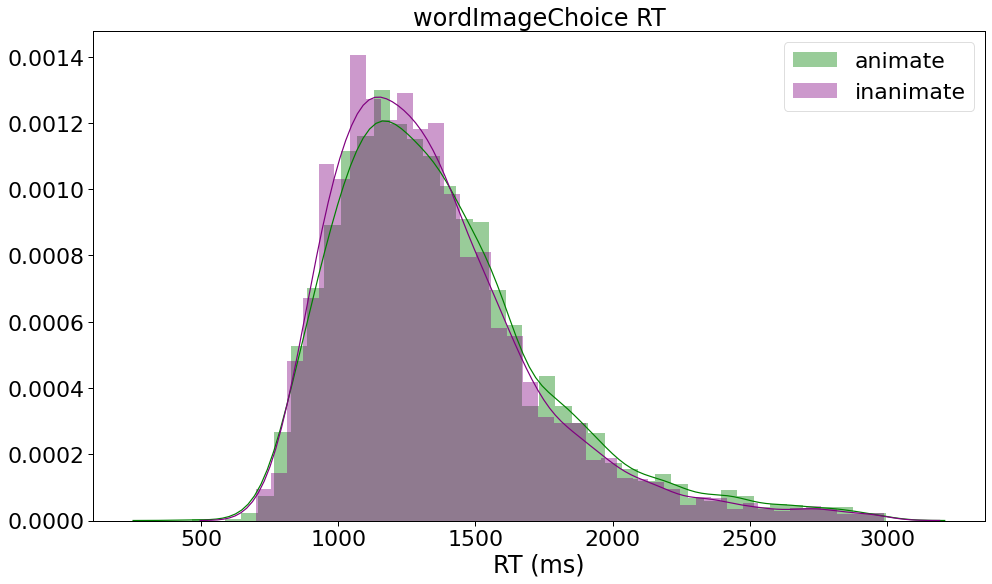

In [48]:
# animate/non-animate
sns.distplot(wi_df[(wi_df["animacy"] == "animate") & (wi_df.relation == "match")]["rt"], color="green", label="animate")
sns.distplot(wi_df[(wi_df["animacy"] == "inanimate") & (wi_df.relation == "match")]["rt"], color="purple", label="inanimate")
plt.legend()
plt.xlabel("RT (ms)")
plt.title("wordImageChoice RT")

### wordImageChoice acc

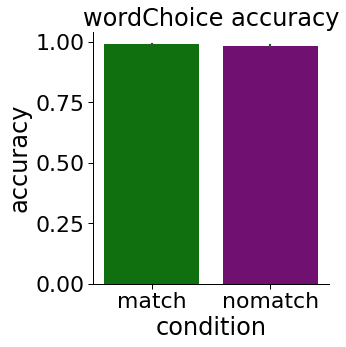

In [49]:
# accuracy
sns.catplot(x="relation", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=wi_df)
plt.xlabel("condition")
plt.ylabel("accuracy")
plt.title("wordChoice accuracy")
plt.savefig("./figures/wimatch/acc-match.svg", bbox_inches="tight")

## word-image RT

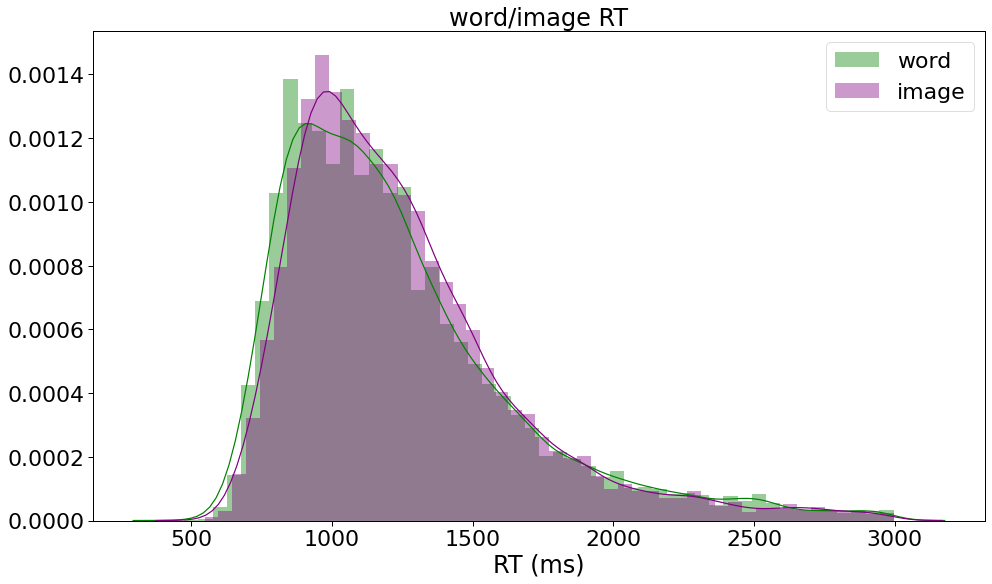

In [50]:
# word/image RT
sns.distplot(word_df["rt"], color="green", label="word")
sns.distplot(image_df["rt"], color="purple", label="image")
plt.legend()
plt.xlabel("RT (ms)")
plt.title("word/image RT")
plt.savefig("./figures/rt-stimuli.svg", bbox_inches="tight")

## save data

In [51]:
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
word_df[word_df.correct == True].to_csv(os.path.join(new_data_path, wordtask + ".csv"), index=False)
image_df[image_df.correct == True].to_csv(os.path.join(new_data_path, imagetask + ".csv"), index=False)
wi_df[wi_df.correct == True].to_csv(os.path.join(new_data_path, witask + ".csv"), index=False)
food_df.to_csv(os.path.join(new_data_path, foodtask + ".csv"), index=False)